C:\Users\AS\AppData\Local\Temp\ipykernel_6764\4195804105.py:56: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft     = QFT(n_q, do_swaps=True).decompose()


Norm of final statevector: 1.0000


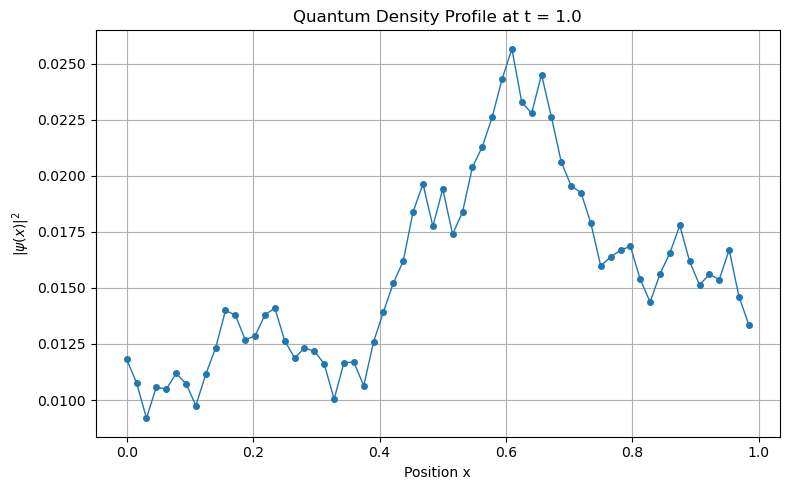

In [24]:
import numpy as np
from math import ceil, log2
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import StatevectorSimulator # Changed to StatevectorSimulator
# try the “modern” import first…
try:
    from qiskit.circuit.library import DiagonalGate
# …fall back if you’re on an older Terra
except ImportError:
    from qiskit.circuit.library.generalized_gates import DiagonalGate
from qiskit.visualization import plot_histogram # Still useful for quick checks
import matplotlib.pyplot as plt # Import matplotlib for custom plotting

# 1. Problem parameters (those can be changed think them as constants)
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required to represent N states
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of Trotter steps (Trotterization depth)
dt      = t_tot / r # Time step for each Trotter slice
hbar    = 1.0 # Planck's constant (set to 1 as per problem note)

# --- Parameters for H_visc ---
delta_0 = 1.0   # As specified in the image: "Take δ0 = 1"
epsilon_0 = 0.1 # Placeholder value, adjust as needed


# 2. Precompute H_visc(x)
x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions from 0 to 1 (exclusive of 1)
dx      = x_vals[1] - x_vals[0] # Spatial step size, needed for k_vals

k_vals_quantum = 2 * np.pi * np.fft.fftfreq(N, d=dx)


H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    # Term 1: ε0^4 π^2 sin^2(πx) cos^2(πx)
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    
    # Base for Term 2: (ε0 cos(x) sin(πx) - ε0 π sin(x) * cos(πx))
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    
    # Base for Term 3: (ε0 sin(x) sin(πx) + ε0 π cos(x) * cos(πx))
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)



# 3. Build QFT & inverse-QFT circuits
# QFT and inv_qft are QuantumCircuit objects themselves after decompose()
qft     = QFT(n_q, do_swaps=True).decompose()
inv_qft = qft.inverse() # Inverse QFT to switch back

def add_kinetic_step(qc: QuantumCircuit):

    # Use qc.compose() to insert the QFT circuit's individual gates into qc
    qc.compose(qft, qubits=range(n_q), inplace=True) # Apply QFT to move to momentum basis
    
    # Calculate the complex phases for each computational basis state |k> (momentum state)
    kinetic_phases = []
    for k_idx in range(2**n_q): # k_idx is the integer index of the basis state
        # Use the precomputed physical momentum value corresponding to this index
        p_k = k_vals_quantum[k_idx] # Corrected: Use physical momentum value
        phi_k = (hbar**2 * p_k**2 / 2) * dt / hbar 
        kinetic_phases.append(np.exp(-1j * phi_k)) # Calculate e^(-i * phi_k)
    


    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(kinetic_phases), range(n_q))
    
    # Use qc.compose() to insert the inverse QFT circuit's individual gates into qc
    qc.compose(inv_qft, qubits=range(n_q), inplace=True) # Apply inverse QFT to move back to position basis

def add_H_visc_step(qc: QuantumCircuit):
 
    H_visc_phases = []
    for x_idx in range(N):
        # The H_visc energy is directly H_visc_array[x_idx]
        # The angle for time evolution is H_visc(x) * dt / hbar
        angle_H_visc = H_visc_array[x_idx] * dt / hbar # Corrected: Divide by hbar
        H_visc_phases.append(np.exp(-1j * angle_H_visc))
    

    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(H_visc_phases), range(n_q))


# 4. Build the main Trotter circuit
qc = QuantumCircuit(n_q, n_q)


epsilon_0_initial = 0.01 # Renamed to avoid clash with H_visc epsilon_0

initial_state_amplitudes = np.zeros(N, dtype=complex)

for i in range(N):
    x_val = x_vals[i] # Get the continuous x value for this grid point

    if x_val <= 0.5:
        # Ψ(x, 0) = cos(x) + i sin(x) + j ε0 sin(πx)
        term1 = np.exp(1j * x_val) # Interpreting cos(x) + i sin(x) as e^(ix)
        term2 = 1j * epsilon_0_initial * np.sin(np.pi * x_val)
        initial_state_amplitudes[i] = term1 + term2
    else: # x_val > 0.5
        # Ψ(x, 0) = cos(0.5) + i sin(0.5) + j ε0 sin(0.5)
        constant_part = np.exp(1j * 0.5) # Interpreting cos(0.5) + i sin(0.5) as e^(i*0.5)
        term2_gt_0_5 = 1j * epsilon_0_initial * np.sin(0.5) # sin(0.5) is a constant here
        initial_state_amplitudes[i] = constant_part + term2_gt_0_5

# Normalize the initial state vector
norm = np.linalg.norm(initial_state_amplitudes)
if norm != 0:
    initial_state_amplitudes = initial_state_amplitudes / norm
else:
    print("Warning: Initial state amplitudes sum to zero. State will be all zeros.")

qc.initialize(initial_state_amplitudes, range(n_q))


# 4.2 Time evolution using Trotter steps
for _ in range(r):
    add_kinetic_step(qc)   # Applies gates that evolve the state due to kinetic energy
    add_H_visc_step(qc)    # Applies gates that evolve the state due to H_visc


# 5. Run on StatevectorSimulator to get the full wave function
backend_statevector = StatevectorSimulator()
qc_compiled = transpile(qc, backend_statevector) 
job_statevector = backend_statevector.run(qc_compiled) # Run the compiled circuit
result_statevector = job_statevector.result()
final_state_vector = np.asarray(result_statevector.get_statevector(qc_compiled)) 

print(f"Norm of final statevector: {np.linalg.norm(final_state_vector):.4f}")


dx = x_vals[1] - x_vals[0] # Spacing between x_vals

# Calculate numerical derivatives
dPsi_dx = np.gradient(final_state_vector, dx)
dPsi_conj_dx = np.gradient(final_state_vector.conj(), dx)

# Get Psi_bar
Psi_conj = final_state_vector.conj()

# Calculate the numerator
numerator = final_state_vector * dPsi_conj_dx - Psi_conj * dPsi_dx

# Calculate the denominator (which is |Psi|^2)
denominator = Psi_conj * final_state_vector

# Add a small epsilon to the denominator to avoid division by zero if |Psi|^2 is exactly zero
# This can happen at nodes of the wavefunction.
epsilon_denom = 1e-10 # A small number
denominator_safe = denominator + epsilon_denom * (denominator == 0) # Add epsilon only where denominator is zero


# --- Plotting ---

# Plot 1: Probability Density |ψ(x)|^2 (same as before)
plt.figure(figsize=(8,5))
# Plotting the exact |psi(x)|^2 from StatevectorSimulator
plt.plot(x_vals, np.abs(final_state_vector)**2, marker='o', linestyle='-', markersize=4, linewidth=1)
plt.xlabel('Position x')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Quantum Density Profile at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('quantum_density_profile.png', dpi=300, bbox_inches='tight')
plt.show()



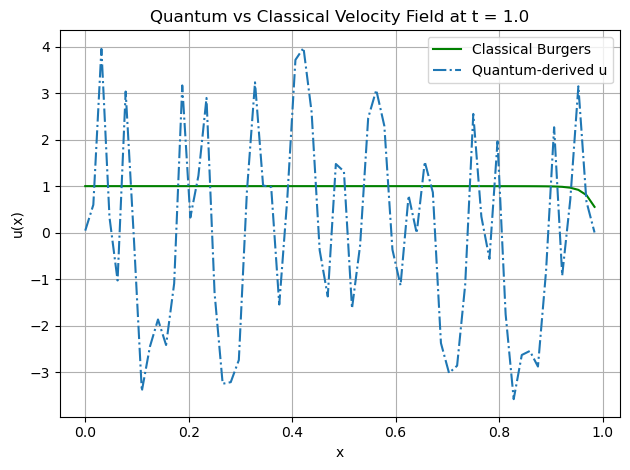

In [23]:
# Classical Burgers' equation solver (viscous)
import numpy as np
import matplotlib.pyplot as plt

# Parameters (aligned with your quantum sim)
N = 64
x = np.linspace(0, 1, N, endpoint=False)
dx = x[1] - x[0]
dt = 0.001
t_tot = 1.0
nt = int(t_tot / dt)
nu = 0.01  # viscosity (analogous to ε₀^2 or similar)

# Initial condition (similar to your ψ-based u)
u0 = np.real(np.exp(1j * x)) + 0.01 * np.sin(np.pi * x)  # real part + perturbation
u = u0.copy()

# Time evolution loop
for n in range(nt):
    un = u.copy()
    u[1:-1] = (un[1:-1] -
               un[1:-1] * dt / dx * (un[1:-1] - un[:-2]) +
               nu * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[:-2]))

# Plot
plt.plot(x, u, label="Classical Burgers",color='green')
plt.plot(x_vals, u_velocity, label="Quantum-derived u", linestyle='-.')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Quantum vs Classical Velocity Field at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.show()
